# S&P 500 Machine learning Project

## Describe the data

In [42]:
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import datetime  # For date conversion 
import pandas_datareader.data as web #Web method to read data from web

import pandas as pd
import matplotlib.pyplot as plt # for plots
import seaborn as sns
import numpy as np
%matplotlib inline

In [43]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [44]:
sp500.index = pd.to_datetime(sp500.index)

In [45]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,0,0
1950-01-04,16.85,16.85,16.85,16.85,1890000,0,0
1950-01-05,16.93,16.93,16.93,16.93,2550000,0,0
1950-01-06,16.98,16.98,16.98,16.98,2010000,0,0
1950-01-09,17.08,17.08,17.08,17.08,2520000,0,0


### pattern visualization

<Axes: xlabel='Date'>

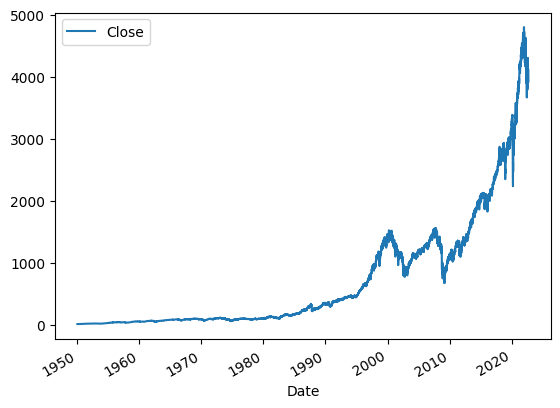

In [46]:
sp500.plot.line(y="Close", use_index=True)

### Data frame set up

In [47]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [48]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [49]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [50]:
sp500 = sp500.loc["1990-01-01":].copy()

### data description

In [51]:
# Data type check
sp500.dtypes

Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Tomorrow    float64
Target        int32
dtype: object

In [52]:
print("Describe Data")
sp500.describe()

Describe Data


,Open,High,Low,Close,Volume,Tomorrow,Target
count,8238.000000,8238.000000,8238.000000,8238.000000,8.238000e+03,8237.000000,8238.000000
mean,1480.612833,1489.366628,1471.188704,1480.891561,2.354003e+09,1481.027679,0.535810
std,976.190436,981.346146,970.496024,976.237482,1.812310e+09,976.218565,0.498746
min,295.450012,301.450012,294.510010,295.459991,0.000000e+00,295.459991,0.000000
25%,875.510025,885.282501,862.060013,875.769989,5.938375e+08,876.070007,0.000000
50%,1244.640015,1254.090027,1234.540039,1244.390015,2.233515e+09,1244.500000,1.000000
75%,1910.107483,1924.809967,1892.739960,1909.727509,3.679338e+09,1909.780029,1.000000
max,4804.509766,4818.620117,4780.040039,4796.560059,1.145623e+10,4796.560059,1.000000


In [53]:
sp500.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Tomorrow    1
Target      0
dtype: int64

## Data analyze

### Let's explore the influence of the Top 4 stocks on the S&P 500 index and investigate their correlation with each other.

In [54]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', '^GSPC']
start = datetime.datetime(2015, 4, 9)
end = datetime.datetime(2020, 4, 9)

top4_df = pd.DataFrame()

# Call yfinance API to fetch data for Top 4 Tickers and S&P 500 for the date range between 2015 and 2020.
for ticker in tickers:
    try:
        df1 = yf.download(ticker, start=start, end=end)
        top4_df[ticker] = df1['Adj Close']
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")

# Also adding Date as a column
top4_df.insert(0, 'Date', top4_df.index)

# Rename S&P 500 column
top4_df.rename(columns={'^GSPC': 'S&P500'}, inplace=True)

top4_df.head()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,AAPL,MSFT,GOOGL,AMZN,S&P500
Date,,,,,,
2015-04-09,2015-04-09,28.509960,36.290333,27.400999,19.177000,2091.179932
2015-04-10,2015-04-10,28.631599,36.500309,27.427000,19.132500,2102.060059
2015-04-13,2015-04-13,28.575283,36.535313,27.431999,19.118000,2092.429932
2015-04-14,2015-04-14,28.451385,36.439068,26.989000,19.255501,2095.840088
2015-04-15,2015-04-15,28.559511,36.972744,27.052000,19.172501,2106.629883


#### Now let us now examine the correlation with other stocks 

Text(0.5, 1.0, 'Top 4 Stocks Correlation with S&P 500')

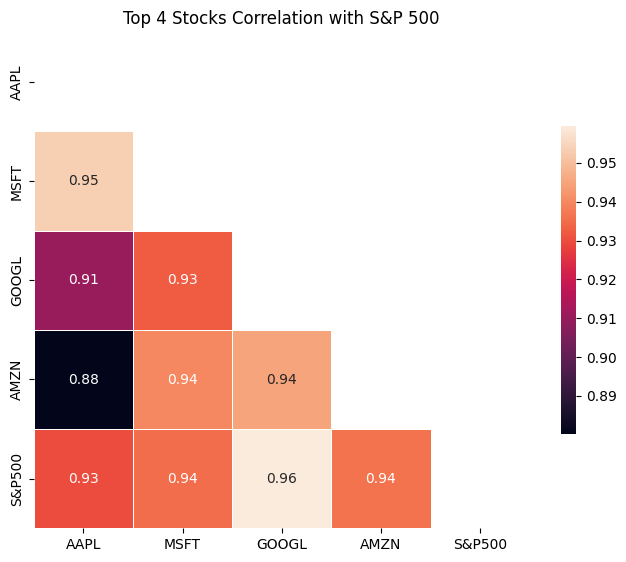

In [55]:
# Calculate correlation matrix
corr = top4_df.drop(columns=['Date']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, annot=True, 
            cbar_kws={"shrink": .5})
ax.set_title('Top 4 Stocks Correlation with S&P 500')


#### The correlation graph above reveals a robust correlation between the S&P 500 stock and the other stocks. This suggests a high degree of synchronicity in the movements of these individual stocks with the S&P 500.

### Returns - S&P 500 and Big 4

#### The rate of return indicates the percentage gained or lost over a specific time frame. This calculation is performed using the following formula:

#### **Rate of Return % = (Current Price - Starting Price) / Starting Price * 100**

#### We will visualize the annual returns of the top 5 major stocks and compare them to the S&P 500's performance over the past five years.

Text(0.5, 1.0, 'Big 5 stocks and S&P 500 Returns in last 5 Years')

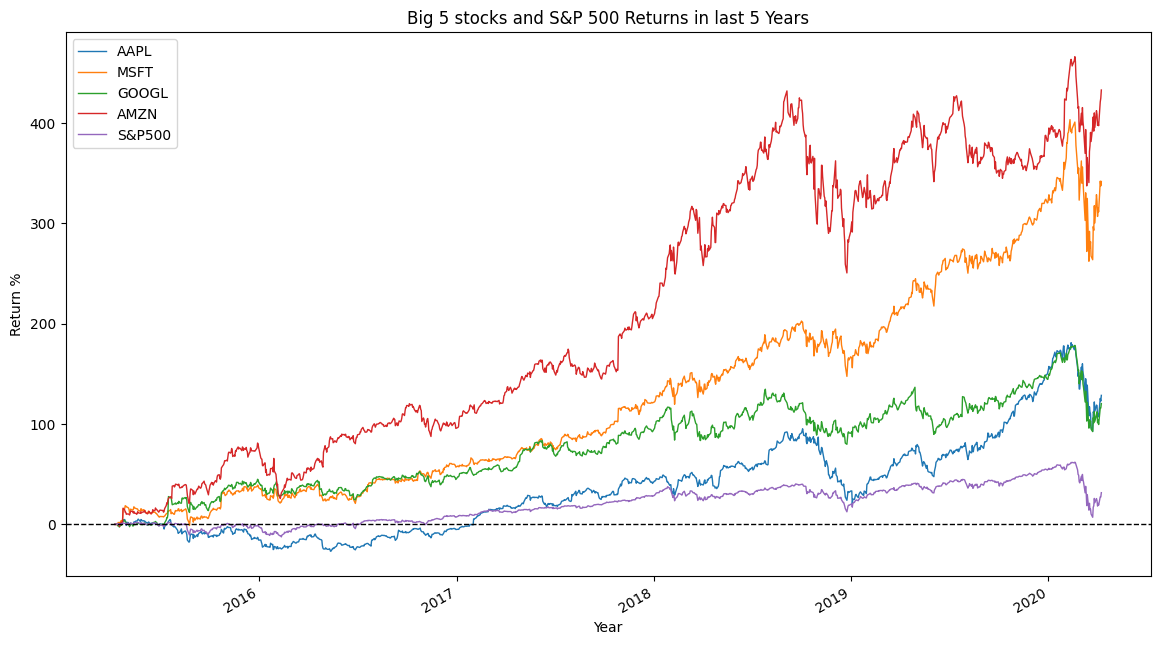

In [56]:
top4_df_dup = top4_df.copy() # make a copy of the close dataframe to make changes

# Removing date field 
top4_df_dup = top4_df_dup.drop(['Date'],axis=1)

# Calculating a Simple return
top4_df_dup = (top4_df_dup - top4_df_dup.iloc[0, :])/top4_df_dup.iloc[0, :]*100 

# plot the rate of return over time
top4_df_dup.plot(legend=True, figsize=(14, 8), linewidth=1)
plt.axhline(y=0, linestyle='dashed', color='black', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Return %')
plt.title('Big 5 stocks and S&P 500 Returns in last 5 Years')

## S&P 500 Prediction

In [57]:
from sklearn.ensemble import RandomForestClassifier


train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]


In [58]:
X_train, X_test, y_train, y_test = train[predictors],test[predictors], train["Target"], test["Target"]

In [59]:
rank_list = []
lr = LogisticRegression(max_iter = 10**6)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
rank_list.append({'model': 'LogisticRegression', 'score': lr_score})

In [60]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
rank_list.append({'model': 'RandomForestClassifier', 'score': rf_score})

In [61]:
svc = SVC()
svc.fit(X_train,y_train)
svc_score = svc.score(X_test, y_test)
rank_list.append({'model': 'SVC', 'score': svc_score})

In [62]:
# rank_list
sorted_rank_list = sorted(rank_list, key=lambda x: x['score'], reverse=True)
for i,mod in enumerate(sorted_rank_list):
    print(f"{i+1}. {mod['model']} - score: {mod['score'].round(3)}")
    

1. RandomForestClassifier - score: 0.53
2. LogisticRegression - score: 0.47
3. SVC - score: 0.47


In [67]:
from sklearn.metrics import precision_score

def score(model, model_name):
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index)
    precision = precision_score(test["Target"], preds)
    print(f"{model_name}: {precision:.2f}")

In [68]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Support Vector Classifier": svc
}

In [69]:
scores = []

for model_name, model in models.items():
    score(model, model_name)
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index)
    precision = precision_score(test["Target"], preds)
    scores.append((model_name, precision))

# Sort scores
scores.sort(key=lambda x: x[1], reverse=True)

print("\nScores sorted by high to low:")
for i, (model_name, precision) in enumerate(scores, start=1):
    print(f"{i}. {model_name}: {precision:.2f}")


Logistic Regression: 0.47
Random Forest: 0.50
Support Vector Classifier: 0.47

Scores sorted by high to low:
1. Random Forest: 0.50
2. Logistic Regression: 0.47
3. Support Vector Classifier: 0.47


#### Here we can tell by now that Random Forest Model gave us the highet accurate score

#### Now let's try to optimize the predoction

In [95]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [96]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [97]:
for model_name, model in models.items():
    predictions = backtest(sp500, model, predictors)
    prediction_counts = predictions["Predictions"].value_counts()
    precision = precision_score(predictions["Target"], predictions["Predictions"])
    target_distribution = predictions["Target"].value_counts() / predictions.shape[0]
    
    print(f"Model: {model_name}")
    print("Prediction Counts:\n", prediction_counts)
    print("Precision Score:", precision)
    print("Target Distribution:")
    for label, percentage in target_distribution.items():
        print(f"{label}: {percentage:.2%}")
    print("\n")


Model: Logistic Regression
Prediction Counts:
 Predictions
1    4738
Name: count, dtype: int64
Precision Score: 0.546855213170114
Target Distribution:
1: 54.69%
0: 45.31%


Model: Random Forest
Prediction Counts:
 Predictions
0    2983
1    1755
Name: count, dtype: int64
Precision Score: 0.5458689458689459
Target Distribution:
1: 54.69%
0: 45.31%


Model: Support Vector Classifier
Prediction Counts:
 Predictions
1    4232
0     506
Name: count, dtype: int64
Precision Score: 0.5465500945179584
Target Distribution:
1: 54.69%
0: 45.31%




In [104]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500.loc[:, ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500.loc[:, trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]


In [105]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [106]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2001-11-20,1151.060059,1152.449951,1142.170044,1142.660034,1330200000,1137.030029,0,0.996338,1.0,0.999559,3.0,1.048050,29.0,0.939880,120.0,0.910431,504.0
2001-11-21,1142.660034,1142.660034,1129.780029,1137.030029,1029300000,1150.339966,1,0.997530,0.0,0.995362,2.0,1.043337,28.0,0.935960,120.0,0.905814,503.0
2001-11-23,1137.030029,1151.050049,1135.900024,1150.339966,410300000,1157.420044,1,1.005819,1.0,1.005588,2.0,1.055740,29.0,0.947516,121.0,0.916289,503.0
2001-11-26,1150.339966,1157.880005,1146.170044,1157.420044,1129800000,1149.500000,0,1.003068,2.0,1.008467,3.0,1.062685,29.0,0.953945,121.0,0.921792,504.0
2001-11-27,1157.420044,1163.380005,1140.810059,1149.500000,1288000000,1128.520020,0,0.996567,1.0,1.001839,2.0,1.055893,29.0,0.947957,121.0,0.915359,503.0


In [110]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
lr = LogisticRegression(max_iter = 10**6)
svc = SVC(probability=True) 
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Support Vector Classifier": svc
}

In [112]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    if hasattr(model, "predict_proba"):
        preds = model.predict_proba(test[predictors])[:, 1]
    else:  # For SVC, use decision_function
        preds = model.decision_function(test[predictors])
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [115]:
import warnings
for model_name, model in models.items():
    predictions = backtest(sp500, model, new_predictors)
    print(f"Model: {model_name}")
    print(predictions["Predictions"].value_counts())

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        precision = precision_score(predictions['Target'], predictions['Predictions'], zero_division=0)
        
    print(f"Precision Score: {precision}")
    print(predictions["Target"].value_counts() / predictions.shape[0])
    print("=" * 50)

Model: Logistic Regression
Predictions
0.0    2648
1.0      90
Name: count, dtype: int64
Precision Score: 0.6
Target
1    0.544193
0    0.455807
Name: count, dtype: float64
Model: Random Forest
Predictions
0.0    2290
1.0     448
Name: count, dtype: int64
Precision Score: 0.5089285714285714
Target
1    0.544193
0    0.455807
Name: count, dtype: float64
Model: Support Vector Classifier
Predictions
0.0    2738
Name: count, dtype: int64
Precision Score: 0.0
Target
1    0.544193
0    0.455807
Name: count, dtype: float64


In [119]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(predictions):
    accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
    precision = precision_score(predictions["Target"], predictions["Predictions"], zero_division=0)
    recall = recall_score(predictions["Target"], predictions["Predictions"])
    f1 = f1_score(predictions["Target"], predictions["Predictions"])
    return accuracy, precision, recall, f1


best_model = None
best_f1_score = 0.0

for model_name, model in models.items():
    predictions = backtest(sp500, model, new_predictors)
    accuracy, precision, recall, f1 = evaluate_model(predictions)
    
    print(f"Model: {model_name}")
    print(predictions["Predictions"].value_counts())
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("=" * 50)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model_name

best_model_info = f"The best model is: \033[1m{best_model}\033[0m with an F1-Score of {best_f1_score:.4f}"
print(best_model_info)


Model: Logistic Regression
Predictions
0.0    2648
1.0      90
Name: count, dtype: int64
Accuracy: 0.4624
Precision: 0.6000
Recall: 0.0362
F1-Score: 0.0684
Model: Random Forest
Predictions
0.0    2290
1.0     448
Name: count, dtype: int64
Accuracy: 0.4587
Precision: 0.5089
Recall: 0.1530
F1-Score: 0.2353
Model: Support Vector Classifier
Predictions
0.0    2738
Name: count, dtype: int64
Accuracy: 0.4558
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
The best model is: Random Forest with an F1-Score of 0.2353


#### Create a visualization using Seaborn to compare the evaluation metrics (Accuracy, Precision, Recall, and F1-Score) of the models

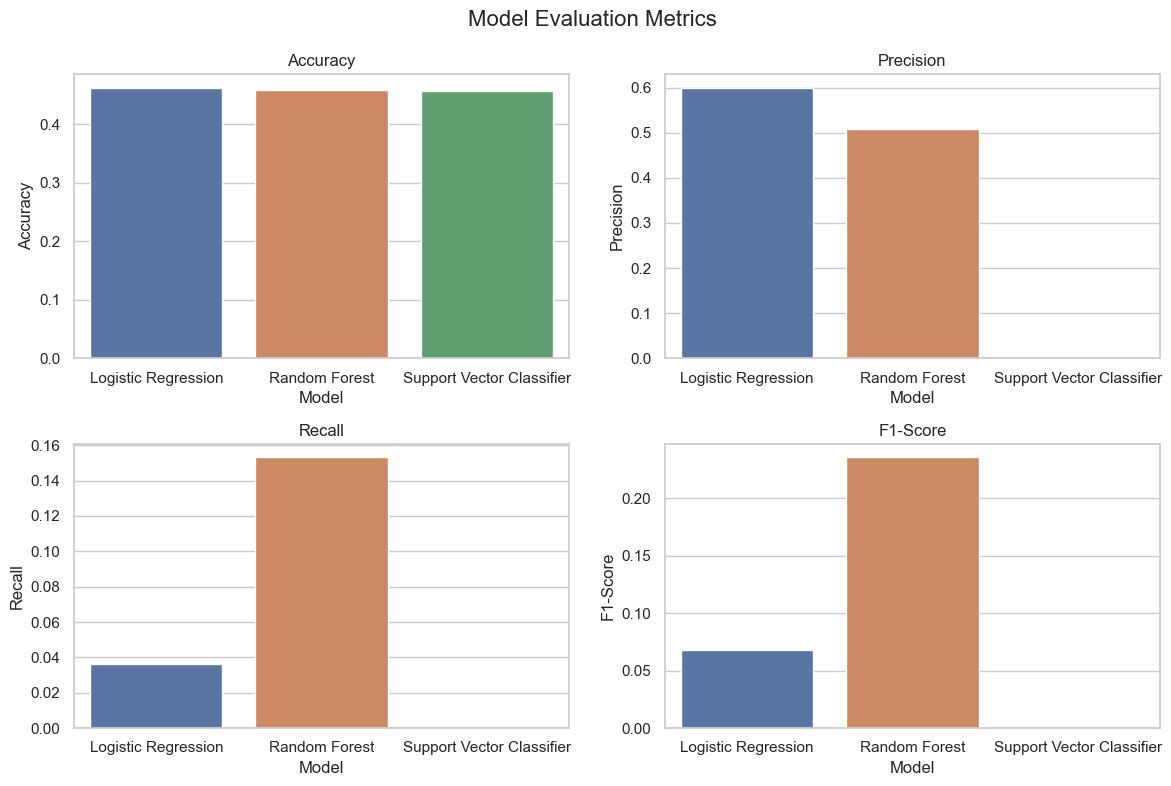

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (your existing code for model evaluation)

# Create a list to store the metrics for each model
metrics_data = []

for model_name, model in models.items():
    predictions = backtest(sp500, model, new_predictors)
    accuracy, precision, recall, f1 = evaluate_model(predictions)
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert the metrics data into a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Set up Seaborn style
sns.set(style="whitegrid")

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Model Evaluation Metrics", fontsize=16)

# Plot the metrics using Seaborn
sns.barplot(x="Model", y="Accuracy", data=metrics_df, ax=axes[0, 0])
axes[0, 0].set_title("Accuracy")

sns.barplot(x="Model", y="Precision", data=metrics_df, ax=axes[0, 1])
axes[0, 1].set_title("Precision")

sns.barplot(x="Model", y="Recall", data=metrics_df, ax=axes[1, 0])
axes[1, 0].set_title("Recall")

sns.barplot(x="Model", y="F1-Score", data=metrics_df, ax=axes[1, 1])
axes[1, 1].set_title("F1-Score")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


In [124]:
predictions

,Target,Predictions
Date,,
2011-10-25,1,0.0
2011-10-26,1,0.0
2011-10-27,1,0.0
2011-10-28,0,0.0
2011-10-31,0,0.0
...,...,...
2022-09-06,1,0.0
2022-09-07,1,0.0
2022-09-08,1,0.0
